<a href="https://colab.research.google.com/github/jagadeesh-sagar/Blog-cms-using-Django/blob/main/Recommender_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Product Recommendation Engine
#### Social and information Networks Project
#### By Ritika Kayal

## Initialisation

In [26]:
# Import libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain
%matplotlib inline

In [6]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
#Import data set
df = pd.read_excel('/content/sample_data/Online Retail.xlsx', header = 0)

In [11]:
print('dataset dimensions are:', df.shape)
df.describe(include = 'all')

dataset dimensions are: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909.0,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900.0,4070,4223,NaN,NaN,NaN,NaN,38
top,573585.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,NaN,United Kingdom
freq,1114.0,2313,2369,NaN,NaN,NaN,NaN,495478
mean,NaN,NaN,NaN,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570,NaN
min,NaN,NaN,NaN,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,2011-03-28 11:34:00,1.250000,13953.000000,NaN
50%,NaN,NaN,NaN,3.000000,2011-07-19 17:17:00,2.080000,15152.000000,NaN
75%,NaN,NaN,NaN,10.000000,2011-10-19 11:27:00,4.130000,16791.000000,NaN
max,NaN,NaN,NaN,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000,NaN


In [12]:
#Taking a smaller set of the data to speed up computations
df_sample = df.iloc[:4000]

## Data Pre-processing

In [13]:
#Delete rows with no Customer ID (if there is such a case)
cleaned_retail = df_sample.loc[pd.isnull(df_sample.CustomerID)==False]

#Create a lookup table
item_lookup = cleaned_retail[['StockCode', 'Description']].drop_duplicates()
item_lookup['StockCode'] = item_lookup.StockCode.astype(str)

#Data cleaning' to raw data
cleaned_retail['CustomerID'] = cleaned_retail.CustomerID.astype(int)
cleaned_retail = cleaned_retail[['StockCode', 'Quantity', 'CustomerID']]
grouped_cleaned = cleaned_retail.groupby(['CustomerID', 'StockCode']).sum().reset_index()
print()
grouped_cleaned.Quantity.loc[grouped_cleaned.Quantity == 0] = 1
grouped_purchased = grouped_cleaned.query('Quantity > 0')


<ipython-input-13-a50eeca40dda>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_retail['CustomerID'] = cleaned_retail.CustomerID.astype(int)
<ipython-input-13-a50eeca40dda>:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, t

In [14]:
#Count number of products and number of customers in the reduced dataset
no_products = len(grouped_purchased.StockCode.unique())
no_customers = len(grouped_purchased.CustomerID.unique())
print('Number of customers in dataset:', no_customers)
print('Number of products in dataset:', no_products)

Number of customers in dataset: 137
Number of products in dataset: 1131


## Create a Bipartite Graph

In [15]:
#Turn raw data to pivot ('ratings' matrix)
ratings = grouped_purchased.pivot(index = 'CustomerID', columns='StockCode', values='Quantity').fillna(0).astype('int')
#Binarize the ratings matrix (indicate only if a customer has purchased a product or not)
ratings_binary = ratings.copy()
ratings_binary[ratings_binary != 0] = 1

## Convert to a Weighted Product Graph

In [16]:
#Initialize zeros dataframe for product interactions
products_integer = np.zeros((no_products,no_products))

#Count how many times each product pair has been purchased
print('Counting how many times each pair of products has been purchased...')
for i in range(no_products):
    for j in range(no_products):
        if i != j:
            df_ij = ratings_binary.iloc[:,[i,j]] #create a temporary df with only i and j products as columns
            sum_ij = df_ij.sum(axis=1)
            pairings_ij = len(sum_ij[sum_ij == 2]) #if s1_ij == 2 it means that both products were purchased by the same customer
            products_integer[i,j] = pairings_ij
            products_integer[j,i] = pairings_ij

Counting how many times each pair of products has been purchased...


In [17]:
#Count how many customers have purchased each item
print('Counting how many times each individual product has been purchased...')
times_purchased = products_integer.sum(axis = 1)

Counting how many times each individual product has been purchased...


In [18]:
#Construct final weighted matrix of item interactions
print('Building weighted product matrix...')
products_weighted = np.zeros((no_products,no_products))
for i in range(no_products):
    for j in range(no_products):
        if (times_purchased[i]+times_purchased[j]) !=0: #make sure you do not divide with zero
            products_weighted[i,j] = (products_integer[i,j])/(times_purchased[i]+times_purchased[j])

Building weighted product matrix...


## Visualise Weighted Product matrix

In [19]:
#Get list of item labels (instead of Codes)
nodes_codes = np.array(ratings_binary.columns).astype('str')
item_lookup_dict = pd.Series(item_lookup.Description.values,index=item_lookup.StockCode).to_dict()
nodes_labels = [item_lookup_dict[code] for code in nodes_codes]

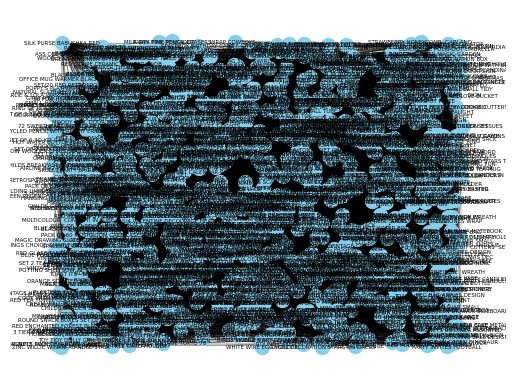

In [21]:
#Create Graph object using the weighted product matrix as adjacency matrix
G = nx.from_numpy_array(products_weighted)
pos=nx.random_layout(G)
labels = {}
for idx, node in enumerate(G.nodes()):
    labels[node] = nodes_labels[idx]

nx.draw_networkx_nodes(G, pos , node_color="skyblue", node_size=100)
nx.draw_networkx_edges(G, pos,  edge_color='k', width= 0.3, alpha= 0.5)
nx.draw_networkx_labels(G, pos, labels, font_size=4)
plt.axis('off')
plt.show()

#### For better visualisation, export the graph to Gephi

In [22]:
#Export graph to Gephi
H=nx.relabel_nodes(G,labels) #create a new graph with Description labels and save to Gephi for visualizations
nx.write_gexf(H, "products.gexf")

## Louvain Clustering

In [23]:
# function for setting colors of nodes and edges
def get_paired_color_palette(size):
    palette = []
    for i in range(size*2):
        palette.append(plt.cm.Paired(i))
    return palette

#Find communities of nodes (products)
louvain = community_louvain.best_partition(G, resolution = 1.5)
values = list(louvain.values())

communities =[]

for i in set(louvain.values()):
    nodelist = [n for n in G.nodes if (louvain[n]==i)]
    communities.append(nodelist)

## Visualise detected communities

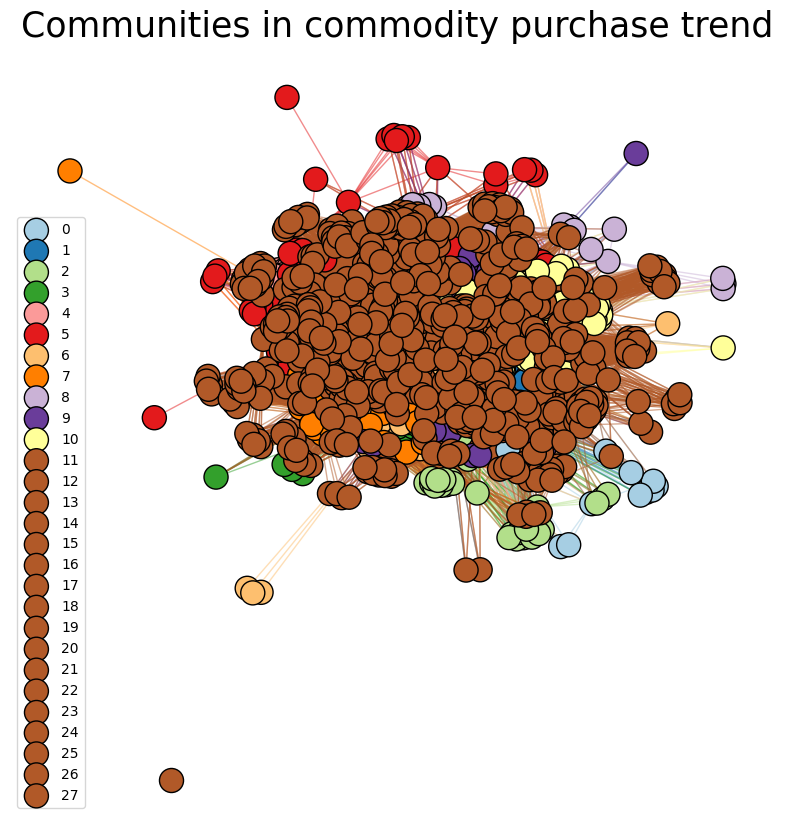

In [24]:
#make plot using matplotlib, networkx spring_layout, set_colors using cluster_count and get_paired_color_pallette
clusters_count = len(set(louvain.values()))
plt.figure(figsize=(10, 10))
light_colors = get_paired_color_palette(clusters_count)
dark_colors = get_paired_color_palette(clusters_count)
g = nx.drawing.layout.spring_layout(G, weight = 'weight')

#iterate through each of the communities found by the Louvain algorithm and plot
for i in set(louvain.values()):
    nodelist = [n for n in G.nodes if (louvain[n]==i)]
    edgelist = [e for e in G.edges if ((louvain[e[0]]==i) or (louvain[e[1]]==i))]
    node_color = [light_colors[i] for _ in range(len(nodelist))]
    edge_color = [dark_colors[i] for _ in range(len(edgelist))]
    nx.draw_networkx_nodes(G, g, nodelist=nodelist, node_color=node_color, edgecolors='k', label = i)
    nx.draw_networkx_edges(G, g, edgelist=edgelist, alpha=.5, edge_color=edge_color)

#set title, legend and show plot
plt.title('Communities in commodity purchase trend', fontdict={'fontsize': 25})
plt.legend()
plt.axis('off')
plt.show()

## Performance Metrics

## Detected Community Analysis

In [32]:
#Check how many communities were created
print('Number of communities:', len(np.unique(values)))

Number of communities: 28


In [33]:
#Create dataframe with product description and community id
products_communities = pd.DataFrame(nodes_labels, columns = ['product_description'])
products_communities['community_id'] = values

In [34]:
#Community 1
products_communities[products_communities['community_id']==1].head(40)

,product_description,community_id
1,MINI FUNKY DESIGN TAPES,1
47,BLUE ROSE FABRIC MIRROR,1
49,SET/9 CHRISTMAS T-LIGHTS SCENTED,1
102,SET/10 RED POLKADOT PARTY CANDLES,1
160,SKULLS WRITING SET,1
161,BALLOONS WRITING SET,1
162,DINOSAURS WRITING SET,1
281,COSY SLIPPER SHOES SMALL RED,1
308,HEART T-LIGHT HOLDER,1
309,STAR T-LIGHT HOLDER,1


## Product Recommendation

In [36]:
#Turn into dataframe
products_weighted_pd = pd.DataFrame(products_weighted, columns = nodes_labels)
products_weighted_pd.set_index(products_weighted_pd.columns, inplace=True) # Remove extra argument 'product'
#products_weighted_pd.index.name = 'product' # if you need to name the index column

products_prob = products_weighted_pd.divide(products_weighted_pd.max(axis = 1), axis = 0)

In [37]:
#Saving the trained model for use in the UI
products_prob.to_csv('products_prob.csv')

---
## Testing



In [38]:
#Add item to basket
basket = ['HOME BUILDING BLOCK WORD']
#Select the number of relevant items to suggest
no_of_suggestions = 3

all_of_basket = products_prob[basket]
all_of_basket = all_of_basket.sort_values(by = basket, ascending=False)
suggestions_to_customer = list(all_of_basket.index[:no_of_suggestions])

print('You may also consider buying:', suggestions_to_customer)

You may also consider buying: ['ASSORTED COLOUR BIRD ORNAMENT', 'BATH BUILDING BLOCK WORD', 'LOVE BUILDING BLOCK WORD']
